# Introduction
This notebook gives an example how we reach the decision which algorithm to choose for our final predictive model. It is the second notebook in a our series (of 5 notebooks in total) and relies on the results from the previous one, 1_explore_R.ipynb, which should be run in advance.  

For a better understanding you should have **basic knowledge of predictive modelling**, i.e. know what a logistic regression is or cross-validation, for instance.  

As example data source the well known **titanic data set** is chosen (https://www.kaggle.com/c/titanic/data). It is therefore a classification problem with the binary target *survived/not survived*. Even though you cannot compare the titanic case with a real life setting, the following steps pretty much reflect (on a small scale!) how we conduct data analysis in all our predictive modeling projects.

<br><br>
# 0 Initialization

We start by loading  the results from this preceeding notebook. Then we do some basic settings and load packages (including the important hmsPM package comprising highly helpful functions used in the following) by sourcing 0_init.R in the exact same way we did in 1_explore_R.ipynb.

After that we initialize a cluster in order to process the forthcoming steps in parallel where possible. E.g all the tuning steps are done by utilizing the caret package which automatically conducts the tuning in parallel as long as a cluster is registered. Below we use just 4 processors on a 4-core laptop. Usually you run the following steps on a server or virtual machine of at least 16 cores as a recommendation.

In [1]:
# Load result from exploration
setwd("C:/MY/hmsPM_R/hmsPM/inst/example") 
load(paste0("data/","1_explore.rdata"))

# Load libraries and functions
suppressMessages(source("./code/0_init.R"))

# Initialize parallel processing
cl = makeCluster(as.numeric(Sys.getenv("NUMBER_OF_PROCESSORS")))
registerDoParallel(cl)
#clusterEvalQ(cl, library(hmsPM))
# stopCluster(cl); closeAllConnections() #stop cluster

In [2]:
summary(df[features_notree])

      age            fare_LOG_        fare_pp            pclass   
 Min.   : 0.1667   Min.   :0.000   Min.   : 0.00   1st      :323  
 1st Qu.:21.0000   1st Qu.:2.186   1st Qu.: 7.55   2nd      :277  
 Median :28.0000   Median :2.738   Median : 8.05   3rd      :709  
 Mean   :29.9080   Mean   :2.977   Mean   :14.45   (Missing):  0  
 3rd Qu.:39.0000   3rd Qu.:3.474   3rd Qu.:15.03                  
 Max.   :65.0000   Max.   :5.574   Max.   :55.44                  
                                                                  
        sex          sibsp         parch             embarked  
 female   :466   0      :891   0      :1002   Southampton:914  
 male     :843   1      :319   1      : 170   Cherbourg  :270  
 (Missing):  0   2      : 42   2      : 113   Queenstown :123  
                 4      : 22   3      :   8   (Missing)  :  2  
                 3      : 20   4      :   6                    
                 8      :  9   5      :   6                    
                

<br><br>
# 1 Test an algorithm (and determine parameter grid)  
In this section we test different algorithms and determine a rough paramter grid we will be using in the model comparison section.
<br>
## 1.1 Sample data
We start by sampling from our data in order to do a quick check of the following processing. Once we have finished that and are sure that everything works correctly we can increase the sampling rate or even use the full data (actually for titanic data there is no difference at all and the sampling is only for illustrating purpose).  

Be aware that we are not doing a simple random sampling but already honor the usual situation of **unbalanced data** in a classification task, i.e. where the interesting class is underrepresented (i.e. the minority class). For titanic data the imbalance is small (38% survived) but in real life you often face highly imbalanced data (e.g. approx. 6% claim rate in car insurance).  
The **undersampling** in the following step takes as many data from the minority class (which comprises the distinguishing information) as well as from the majority class **but** *n_max_per_level* at most, which lead to an undersampling of the majority class in case this parameter has a low value. Usually you take all the data from the minority class and add at least the same amount from the majority class (to get balanced data) or even more which would result in unbalanced data again but not as unbalanced as the original data.  

Here we undersample the whole data. In the following code snippet you see some commented lines which reflect the approach to only undersample the training data but keep the test data as it is. Actually you only need the undersampling for faster training by not using all the data in hand which is often unnecessary with regard to the majority class.  
Some people share the opinion that you need to balance your data in case you use tree-based algorithms. Actually this is not our experience as long as you care about proper tuning of your algorithm. Therefore our single reason for undersampling is to make the training of the model faster.

In [3]:
  # Sample from all data (take all but n_maxpersample at most)
  c(df.tune, b_sample, b_all) %<-%  (df %>% hmsPM::undersample_n(n_max_per_level = 5e2))
  # # Undersample only training data
  # c(df.tmp, b_sample, b_all) %<-%  (df %>% filter(fold == "train") %>% hmsPM::undersample_n(n_max_per_level = 5e3)) 
  # df.tune = bind_rows(df.tmp, df %>% filter(fold == "test"))

  print(summary(df.tune$target)); print(b_sample); print(b_all) #print new target distribution together with the new and old imbalance rate

  N   Y 
500 500 
  N   Y 
0.5 0.5 
       N        Y 
0.618029 0.381971 


<br>  
## 1.2 Define possible cross-validation strategies
Before we start to test (and tune) our algorithms, where we higly rely on the **caret R-package** (http://topepo.github.io/caret/index.html), we need to define the cross-validation strategy. Usually for tuning we do not use the gold standard of 5-fold as this takes too long to process and decide for a "1-fold", i.e. just take already defined (in 1_explore_R.ipynb) test data as the hold-out fold. This is reflected in the following *ctrl_idx* which is later used as control setting for the tuning.  
We additionally already define some alternative control sets which refuses any **parallel tuning processing**. We need this control for a deep learning algorithm for instance or the standard "xgbTree" caret wrapper in conjunction with a sparse matrix which cannot be done in parallel, see also explanation below. We also add the 5-fold cross validation for the rare cases we would like to check the variability in the tuning results.

All these predefined controls use the general *hmsPM::performance_summary* function to calculate the performance metrics and can be used for regression and classification as well.  

One more hint regarding the "fff" suffixed controls: By using the indexFinal option in the trainControl function we tell the train function which is doing the tuning in a later step to process the final fit with the best tuning parameter set just on a small subset of data in order to make this unnecessary step (as we only want to find the best tuning parameter) as fast as possible.

In [4]:
l.index = list(i = which(df.tune$fold == "train")) #take predefined train set
#set.seed(998); #l.index = list(i = sample(1:nrow(df.tune), floor(0.8*nrow(df.tune)))) #random train set as alternative

# Index based test-set
ctrl_idx = trainControl(method = "cv", number = 1, index = l.index,
                        returnResamp = "final", returnData = FALSE,
                        summaryFunction = hmsPM::performance_summary, classProbs = TRUE)

# Dito but "fast" final fit: DO NOT USE in case of further application!!!
ctrl_idx_fff = ctrl_idx
ctrl_idx_fff$indexFinal = sample(1:nrow(df.tune), 100) #"Fast" final fit!!!

# Dito but without parallel processing: Needed for Lightgbm or DeepLearn
ctrl_idx_nopar_fff = ctrl_idx_fff
ctrl_idx_nopar_fff$allowParallel = FALSE

# Dito as 5-fold cv
ctrl_cv_fff = trainControl(method = "cv", number = 5,
                           returnResamp = "final", returnData = FALSE,
                           summaryFunction = hmsPM::performance_summary, classProbs = TRUE,
                           indexFinal = sample(1:nrow(df.tune), 100)) #"Fast" final fit!!!


<br>  
## 1.3 Test algorithms
Now we can test some algorithms and determine the best tuning parameter set.  

We always restrict ourselves to the following algorithms: Elastic net, Boosted Trees, Deep Nets. Our experience it that you can soften the popular "No free lunch theorem" (which tells you that there is no single best algorithm for all predictive modeling tasks) to a "at least ther is a free breakfast theorem" as Boosted Trees has shown extraordinary performance for tabular data (and Deep nets for image and text data) also in public competitions (www.kaggle.com). Further reasons behind our selection are the following:
- **Elastic Net** is fully interpretable as it provides you standard regression coefficients (the "betas") because it is basically a standard regression model with a small adaption of the loss function which makes it robust against irrelevant or collinear feature; therefore it is a perfect model candidate in real life (big data) situations. If using binned versions of metric variables it is also robust against outliers, skewness and missing values (see also 1_explore_R.ipynb) and also nonlinear effects can be approximated. This gives this algorithm a fair chance for competing with higly flexible black-box algorithms like Boosted Trees or Deep Nets.
- **Boosted Trees** is still the best algorithm regarding predictive performance in case of "tabular data" (no image, speech or text processing) and therefore also the most popular approach on kaggle (www.kaggle.com) for this kind of data, which is not only a result of its predictive performance but also due to its robustness regarding missing values, skewed features, irrelevant or corrlated features, nonlinear effects as well as interaction effects ("effect of age is differnt for male and female"). Basically it is a "sum of trees" where the next tree is fitted on the residuals of the current ensemble before added to the ensemble in a shrinked fashion (i.e. the prediction of each tree is multiplied with a small value, the "shrinkage" parameter). Interestingly, even though it is more a black box algorithm due to the huge amount of trees that are fitted, one can make it nearly fully interpretable when parsing all trees and sum up the feature effects (see the forthcoming 3_interpretation_R.ipynb notebook). Regarding predictive performance it is usually also better than Random Forest, the second popular tree ensemble method, where the ensemble of trees is created by averaging the predictions of all trees in the ensemble. Below we additionally show the tuning for this algorithm as well.
- **Deep Nets** as the pop star of Machine Learning is definitely the best algorithm for image and speech recoginition but (currently) not for non-receptive tasks like standard predictive modeling using tabular data. But it will probably catch up in future also for these tasks. For all these reasons it is recommeded to get familiar with this algorithm especially with the tuning of the Deep Net as this is still no pleasure at all. Deep Nets are Neural Net algorithms with more than 1 layer which have improved in the last decade due to new estimation algorithms with better regularization approaches. Very important for image and speech recognition tasks are special network architectures like convolutional nets and recurrent nets; for tabular the standard architecture is still composed of fully connected layers. 

There are different strategies to find the best tuning parameter. We almost always use a **grid search** starting with a rough grid and narrow it in consecutive steps which is guided by plotting the predictive performance for the tuning grid. If you have some experience with the algorithms you tune, this is still the best option from our perspective. If you are unfamiliar with the current algorithm at hand, a **random sample search** over a detailed grid might be more effective. There are more ambitious parameter search algorithms out there like Bayesian Optimization and others which we seldom give a try due to effort reasons. 

One more hint: It is absolutely important to plot the tuning results and do not use something like "early stopping" as it might happen in the latter case that you make your algorithm unnecessary complicated, e.g. when you receive a better performance by increasing the number of trees in a boosted tree algorithm up to several thousand but receive just a very small improvement regarding predictive performance compared to using just a few hundred trees. This can best be avoided by inspecting the **plot of the performance vs. the tuning parameter grid**.

### 1.3.1 Elastic net
We start with the "glmnet" which is the elastic-net algorithm, i.e. a penalized regression. Here we use the **binned metric variables** which are therefore all categorical in order to help the algorithm to fit also non-linear effects. In case you have a big dataset the creation of the design matrix from these binned variables will comprise a high memory amount due to the 1-hot coding which is done internally by the *train* caret-function. Remind from *1_explor_r.ipynb* that we cannot use any numerical encoding for a "linear" algorithm like elastic net. To keep memory consumption manageable for real life data we can hand over a **sparse matrix** which is much smaller than a dense one due to the many zeros resulting form the 1-hot coding. Unfortunately the standard "glmnet" wrapper provided by the caret package retransforms this sparse to a dense matrix again; so we adapted this wrapper and created a new *glmnet_custom* wrapper which does not do this retransformation. 
Be aware that no additional feature scaling is needed (as usual for an elastic net approach) as all features are scaled between 0 and 1 due to the 1-hot coding.

The plot shows that alpha = 0 and lambda = 0.25 are the best parameter set. This is a little uncommon compred to real data where a pure *lasso penalization* (alpha = 1) usually outperforms a pure *ridge penalization* (alpha = 0).

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

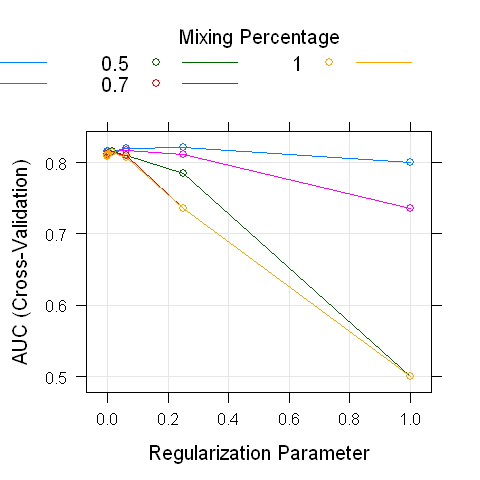

In [5]:
## Lasso / Elastic Net
fit = train(x         = sparse.model.matrix(as.formula(formula_binned),
                                            df.tune[c("target",features_binned)]),
            y         = df.tune$target,
            method    = glmnet_custom,
            trControl = ctrl_idx_fff,
            metric    = "AUC",
            tuneGrid  = expand.grid(alpha = c(0,0.2,0.5,0.7,1),
                                    lambda = 2^(seq(0, -15, -2))))
            #preProc = c("center","scale")) #no scaling needed due to dummy coding of all variables
options(repr.plot.width = 4, repr.plot.height = 4)
plot(fit)

# -> keep alpha=1 to have a full Lasso

### 1.3.2 Boosted Trees
We usually apply the **xgboost** implementation of boosted trees.  

Unfortunately the standard caret wrapper "xgbTree" does not support parallel processing for tuning in conjunction with a **sparse matrix**. We therefore adapted this in the "xgb_custom" wrapper in order to be able to utilize the advantages of a sparse feature matrix.  

Be aware that the tuning grid in the following snippet is far too ambitious for titanic but provides a good start for grid search with real life data. For the titanic data the tuning result shows some instable behaviour due to the small data amount.

We also created an own plot function in the hmsPM package for the fit results as the standard output from the caret package cannot be always conveniently read.

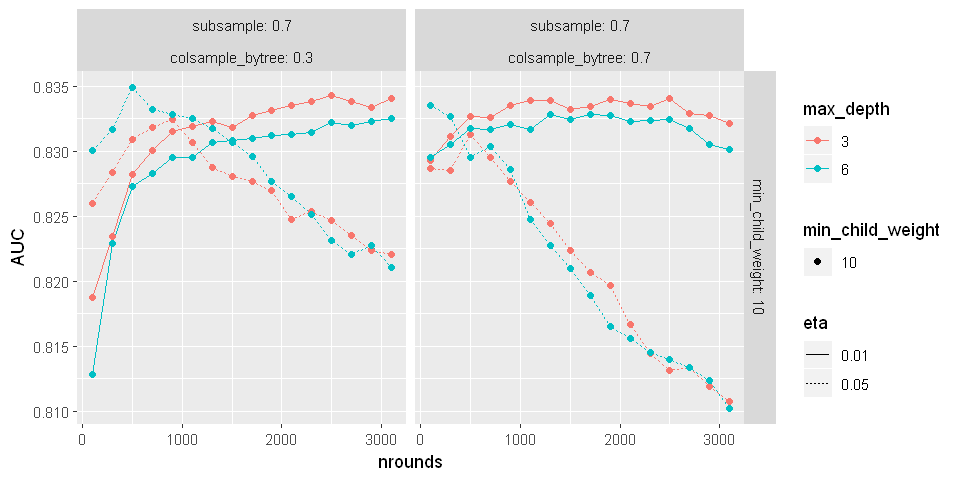

In [6]:
# Overwritten xgbTree: additional alpha and lambda parameter. Possible to use sparse matrix and parallel processing
fit = train(x         = sparse.model.matrix(as.formula(formula), 
                                            df.tune[c("target",features)]), 
            y         = df.tune$target,
            method    = xgb_custom,
            trControl = ctrl_idx_fff, #parallel for overwritten xgb
            metric    = "AUC",
            tuneGrid  = expand.grid(nrounds = seq(100,3100,200), eta = c(0.01,0.05),
                                    max_depth = c(3,6), min_child_weight = c(10),
                                    colsample_bytree = c(0.3, 0.7), subsample = c(0.7),
                                    gamma = 0, alpha = 0, lambda = 1))
options(repr.plot.width = 8, repr.plot.height = 4)
hmsPM::plot_caret_result(fit, metric = "AUC", x = "nrounds",
                  color = "max_depth", linetype = "eta", shape = "min_child_weight",
                  facet = "min_child_weight ~ subsample + colsample_bytree")

In the next commented snippet we show how to use another popular boosted tree implementation, i.e. ***lightgbm*** for which we have also written an own wrapper to use with the caret package. Furthermore an example of using the ***ranger*** implementation of a Random Forest (which is much faster than the standard *randomForest*) is listed.

In [7]:
# # Lightgbm
#  fit = train(x         = df.tune[features],
#              y         = df.tune$target,
#              #fit = train(sparse.model.matrix(as.formula(formula), df.tune[c("target",features)]), df.tune$target,
#              method    = lgbm,
#              trControl = ctrl_idx_nopar_fff,
#              metric    = "AUC",
#              tuneGrid  = expand.grid(nrounds = seq(100,2100,200), learning_rate = c(0.01),
#                                      num_leaves = 32, min_data_in_leaf = c(10),
#                                      feature_fraction = c(0.7), bagging_fraction = c(0.7)),
#              #max_depth = 3, #use for small data
#              verbose   = -1)
 

## Random Forest as alternative
#fit = train(x         = df.tune[features],
#            y         = df.tune$target,
#            #fit = train(x = model.matrix(as.formula(formula), df.tune[c("target",features)]), y = df.tune$target,
#            method    = "ranger",
#            trControl = ctrl_idx_fff,
#            metric    = "AUC",
#            tuneGrid  = expand.grid(mtry = seq(1,length(features),10),
#                                    splitrule = switch(TARGET_TYPE,
#                                                       "CLASS" = "gini", "REGR" = "variance",
#                                                       "MULTICLASS" = "gini") ,
#                                    min.node.size = c(1,5,10)),
#            num.trees = 500) #use the Dots (...) for explicitly specifiying randomForest parameter
# plot(fit)

### 1.3.3 Deep Nets
The following code snippet shows how to train a Deep Net. We use the ***keras*** framework on top of ***tensorflow***. 

We have enlarged the standard caret wrapper in order to also support **different layer architectures**, i.e. several fully connected layers of different size (e.g. size = "10-8-5" describes 3 consecutive layers comprising 10, 8 and 5 units resprecitvely). 

As already explained above, it is hard in case of tabular data to reach the predictive performance of boosted trees. Usually results (also for titanic data) are disappointing unless you put a high effort into tuning.

  size lambda dropout batch_size    lr batch_normalization activation epochs
1   10      0     0.5        100 0.001                TRUE       relu     10
   size lambda dropout batch_size    lr batch_normalization activation epochs
2 10-10      0     0.5        100 0.001                TRUE       relu     10
  size lambda dropout batch_size    lr batch_normalization activation epochs
3   10      0     0.5        100 0.001                TRUE        elu     10
   size lambda dropout batch_size    lr batch_normalization activation epochs
4 10-10      0     0.5        100 0.001                TRUE        elu     10
  size lambda dropout batch_size    lr batch_normalization activation epochs
2   10      0     0.5        100 0.001                TRUE        elu     10


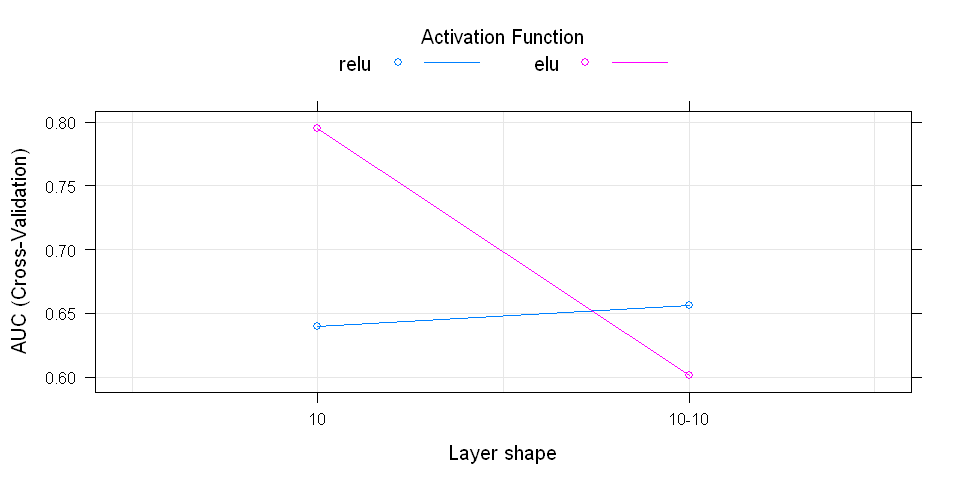

In [8]:
fit = suppressMessages(suppressWarnings(
      train(form      = as.formula(formula_notree),
            data      = df.tune[c("target",features_notree)],
            method    = deepLearn,
            trControl = ctrl_idx_nopar_fff,
            metric    = "AUC",
            tuneGrid  = expand.grid(size = c("10","10-10"),
                                    lambda = c(0), dropout = 0.5,
                                    batch_size = c(100), lr = c(1e-3),
                                    batch_normalization = TRUE,
                                    activation = c("relu","elu"),
                                    epochs = 10),
            preProc = c("center","scale"),
            verbose = 0)
))
plot(fit)

<br><br>
# 2 Evaluate generalization gap for winner algorithm
**Overfitting** is a big problem in Machine Learning. Usually the term overfitting describes the fact that your algorithms predictive performance decreases if you make it too flexible. You fit too near to the train data which decreases the bias but increases variance ("bias-variance-tradeoff") which leads to an overall degraded performance on your test data. This problem can be tackled by appropriate tuning.  

But there is another overfitting problem that still remains in case you use a flexible algorithm (like xgboost for instance). Usually the performance on your training data is better than on your test data still after correct tuning. In fact to a certain extent this is a wished behavior as it shows you that the algorithm can model complex relationships between the input variable and the target. 
But if this ***generalization gap*** (i.e. the difference of predictive performance on training and test data) is getting too big you might find single weird predictions due to outliers in the target variable of the training data. For some businesses these false positives can be critical as they are hard or even impossible to justify (like in credit scoring).  
You can attack the generaltization gap by using more data (see also paragraph "4 Learning curve for winner algorithm" below) or harder **regularization** of your algorithm (e.g. reduce the depth of trees in xgboost) but, as you have already reached the best hold-out performance due to appropriate tuning, this performance will then degrade.  
Big generalization gaps are an overlooked problem in predictive modeling (utilizing Machine Learning), e.g. in kaggle competitions only the predictive performance on the test data is evaluated.  

For a productive solution you should try to reduce the generalization gap, if it seems too big ... where "big" is highly subjective and depends on the business problem you try to solve. The following analysis supports you in finding better tuning parameters, i.e. parameters which **reduce the generalization gap but do not higly degrade the overall performance**.  
E.g in the following plot you would choose the "best" model complexity, instead of the "best ?", even though it does have minimal test error (prediction error on test data) but better balances the generalization gap and the test error.

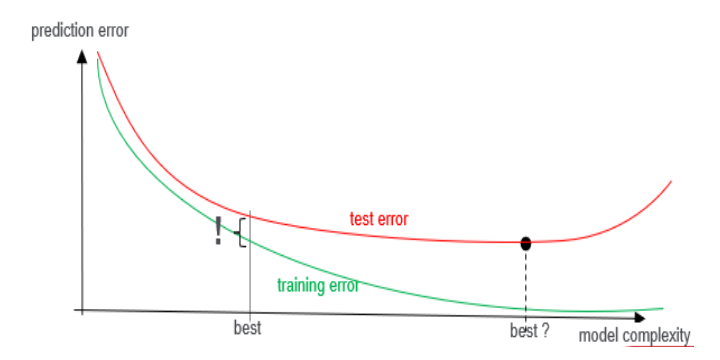

In [9]:
library(png); img = readPNG("DOKU/Bild2.png"); par(mar = c(0,0,0,0)); options(repr.plot.width = 6, repr.plot.height = 3); plot.new();plot.window(0:1, 0:1); rasterImage(img, 0, 0, 1, 1)

<br><br>
For the titanic data we see that reducing the depth of tress from 6 to 3 or increasing the *min_child_weight* value from 5 to 10 and using a smaller number of tress reduces the gap but keeps the test-AUC high. Again, keep in mind that due to the small number of data the results presented for titanic data are not very robust.

[[1]]
NULL


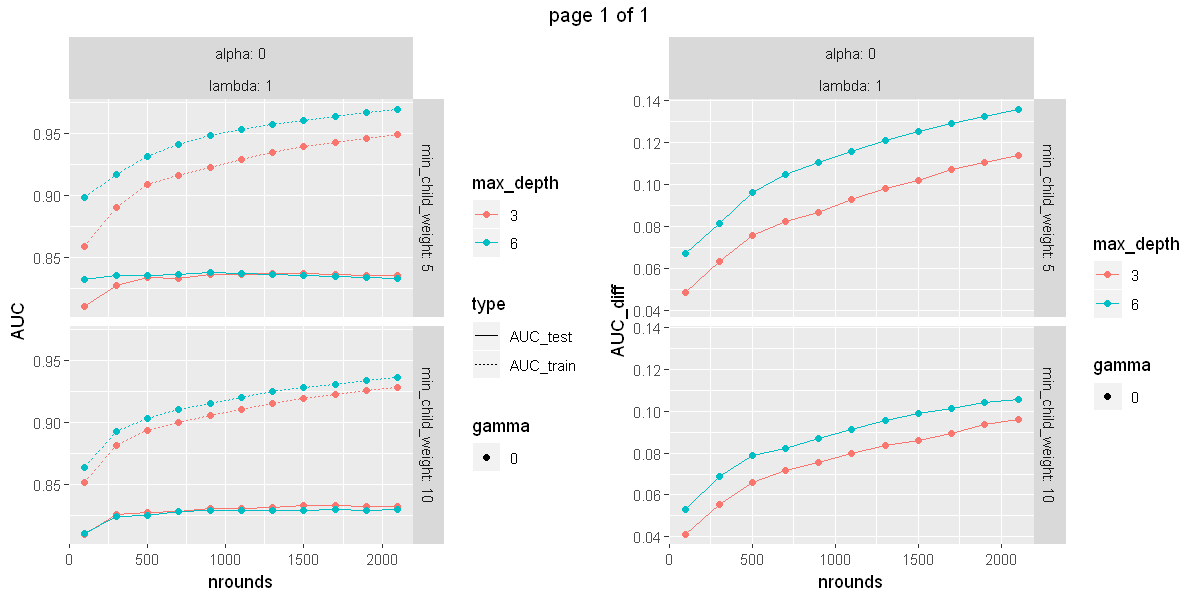

In [10]:
# Sample data (usually undersample training data)
df.gengap = df.tune #%>% sample_n(min(nrow(.),5e3))

# Tune grid to loop over
tunepar = expand.grid(nrounds = seq(100,2100,200), eta = c(0.01),
                      max_depth = c(3,6), min_child_weight = c(5,10),
                      colsample_bytree = c(0.3), subsample = c(0.7),
                      gamma = c(0), alpha = c(0), lambda = c(1))

# Calc generalization gap
df.gengap_result = hmsPM::calc_gengap(df_data        = df.gengap,
                                      formula_string = formula,
                                      sparse         = TRUE,
                                      method         = xgb_custom,
                                      tune_grid      = tunepar,
                                      cluster        = cl)

# Plot generalization gap
options(repr.plot.width = 10, repr.plot.height = 5)
marrangeGrob(hmsPM::plot_gengap(df_gengap = df.gengap_result, 
                                metric    = "AUC", 
                                x         = "nrounds",
                                color     = "max_depth", 
                                shape     = "gamma", 
                                facet     = "min_child_weight ~ alpha + lambda"),
             ncol = 2, nrow = 1)

<br><br>
# 3 Simulation: Compare algorithms
Once we have derived the tuning parameters (or at least a narrow parameter grid) we can compare the predictive performance of different algorithms. This is done in the following snippet. Actually for tabular data we usually just **compare Elastic Net ("glmnet") with Boosted Trees("xgb")**.  

The comparison is done by a simulation which comprises several random sample splits of training and test data and consecutive fitting and testing.
The academic approach for this task would require a **nested cross-validation** (cv) where the inner cv-loop tunes the algorithm and the outer cv-loop compares the algorithms. Usually this takes too long, therefore we apply the comparison in a more pragmatic way as the aim is to get a rough impression of the performance gain of a sophisticated approach like Boosted Trees to a fully interpretable one like Elastic Net and not to compare to other benchmarks which you have to assure for an academic paper.  

The following analysis also helps in **estimating the variablility** of the predictive performance of the algorithms. 

For titanic data there is no difference between the tested algorithms but for real life data you usually see that the gap between Boosted Trees and Elastic Net widens the more features you have. And keep in mind that we already pimped the Elastic Net by binning the metric features.

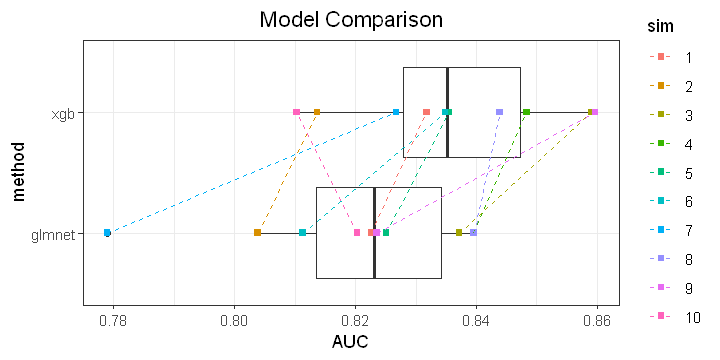

In [11]:
# Basic data sampling (for quick testing)
df.sim = df.tune #%>% sample_n(min(nrow(.),5e3))

# Define methods to run in simulation
l.xgb = list(method         = xgb_custom, 
             formula_string = formula, 
             sparse         = TRUE,
             tune_grid      = expand.grid(nrounds = 2100, eta = c(0.01),
                                          max_depth = c(3), min_child_weight = c(10),
                                          colsample_bytree = c(0.7), subsample = c(0.7),
                                          gamma = 0, alpha = 0, lambda = 1))
l.glmnet = list(method         = glmnet_custom, 
                formula_string = formula_binned, 
                sparse         = TRUE,
                tune_grid      = expand.grid(alpha = 0,
                                             lambda = 2^(seq(4, -10, -2))))

# Simulate
df.sim_result = hmsPM::calc_simulation(df_data           = df.sim,
                                       n_sim             = 10,
                                       metric            = "AUC",
                                       sample_frac_train = 0.8,
                                       sample_frac_test  = 0.5,
                                       l_methods         = list(xgb = l.xgb,
                                                                glmnet = l.glmnet))
options(repr.plot.width = 6, repr.plot.height = 3)
hmsPM::plot_simulation(df.sim_result, metric = "AUC")

<br><br>
# 4 Learning curve for winner algorithm

In Section 2 we mentioned that the generalization gap can be tackled by using more data. This aspect can be visualized with a ***learning curve*** which shows the gap for different number of training records. More pecise, the model is trained for a fraction of the whole training data and the predictive performance is evaluated on this fraction of the training data as well as for the whole test data. Furthermore we can identify whether there is a **saturation in hold-out performance** which might lead to the decision to use less than all data for training in order to safe time and ressources.


A phenotype learning curve looks like in the following png. It usually shows that with just a few training records the in-sample (i.e. train) performance on such a small set with a flexible algorithm is nearly perfect but very low for the whole out-of-sample data (i.e. test). Both effects get weaker the more training data we take.  
Furthermore one can identify that above approx. 300k training records the predictive performance only slightly improves (i.e. it saturates) but the generalization gap is still getting narrower. Anyhow one might decide that this gap is acceptable and due to ressource constraints the training will be restricted to this number of records. 


One important hint: Usually the fraction of training is not just a random sample of the training data but a balanced sample **"as long as balancing is possible"**, e.g. think of training data with 1k records from the minority class and 10k records from the majority class, then up to a sample of 2000 records the sample is balanced.

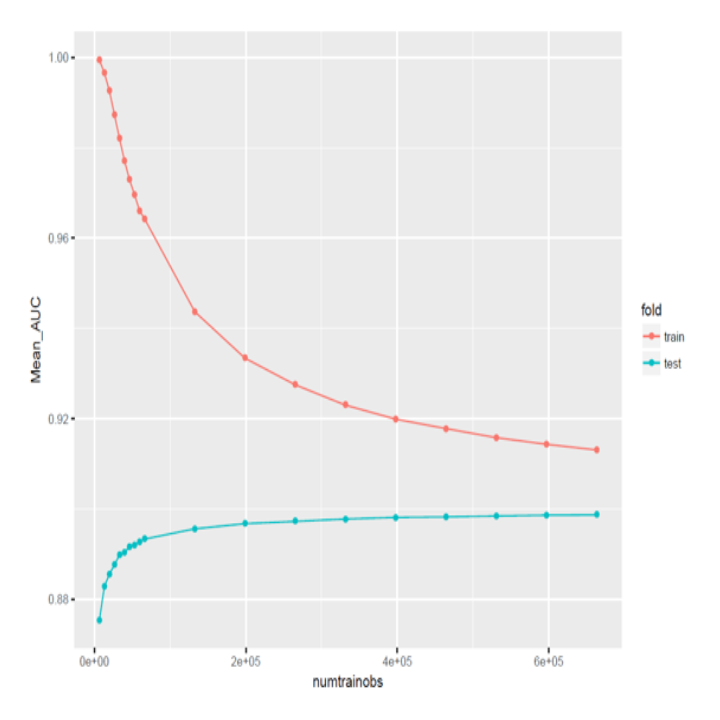

In [12]:
library(png); img = readPNG("DOKU/Bild1.png"); par(mar = c(0,0,0,0)); options(repr.plot.width = 6, repr.plot.height = 6); plot.new();plot.window(0:1, 0:1); rasterImage(img, 0, 0, 1, 1)

For titanic we try balanced samples from 10% up to 100% of the whole training data. Again, for titanic you see some untypical behaviour due to the low number of data records.

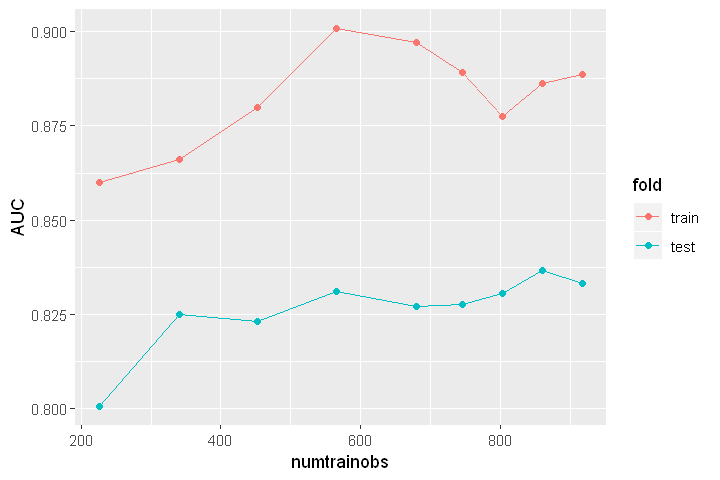

In [13]:
# Basic data sampling (do NOT undersamle as this is done in calc_learningcurve; in fact you finally should not sample at all
df.lc = df #%>% sample_n(min(nrow(.),5e3))

# Tunegrid
tunepar = expand.grid(nrounds = seq(100,500,200), eta = c(0.01),
                      max_depth = c(3), min_child_weight = c(10),
                      colsample_bytree = c(0.3), subsample = c(0.7),
                      gamma = 0, alpha = 0, lambda = 1)

# Calc lc
df.lc_result = hmsPM::calc_learningcurve(df_data        = df.lc,
                                         formula_string = formula,
                                         sparse         = TRUE,
                                         method         = xgb_custom,
                                         tune_grid      = tunepar,
                                         chunks_pct     = seq(20,100,10),
                                         balanced       = TRUE,
                                         metric         = "AUC")
options(repr.plot.width = 6, repr.plot.height = 4)
hmsPM::plot_learningcurve(df.lc_result, metric = "AUC")

<br> <br>
We have finished the model comparison section. The goals of above processing are the following: 
- **decide for an algorithm**
- **determine the tuning parmeter (or at least a fine grid of them)**
- **get an impression of the variability of the algorithms predictive performance ...**
- **... as well how it compares to other approaches**
- **investigate whether we need all the training data**
- **how big will be the generalization gap for the final model**


All these aspects are important to know for the final model which will be further investigated in the forthcoming notebook "3_interpretation_R.ipynb"